In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
sys.path.append("/home/lhz/Workplace/General Execute Architecture/")

from dataclasses import dataclass
from typing import Optional, Union, Tuple, Dict, List, Any

import torch
import torch.nn.functional as F
from transformers import (
    PreTrainedModel, 
    PreTrainedTokenizer, 
    AutoTokenizer,
    LlamaForCausalLM,
    LlamaConfig,
)
from transformers.utils.generic import PaddingStrategy

from gea.metric.metrics import MetricBase, StateMetric, DistanceMetric, MergeMethod
from gea.eval.experiment import Experiments
from gea.eval.benchmark import get_benchmark, SequenceOutputs
from gea.model.template import MODEL_TEMPLATES
from gea.self.xAdaptive.modeling_xAdaptive import xAdaptiveForCausalLM

In [2]:
@dataclass
class DataCollatorForCasualLM:
    processor: PreTrainedTokenizer
    padding: Union[bool, str, PaddingStrategy] = True
    truncation: Union[bool, str] = True
    max_length: int = 20
    pad_to_multiple_of: Optional[int] = None
    return_tensors: str = "pt"
    ignore_index: int = -100
    def __call__(self, features: Union[Dict[str, Any], List[Dict[str, Any]]]) -> Dict[str, Any]:
        input_ids = [feature['input_ids'] for feature in features]
        input_ids = self.processor(
            input_ids,
            padding=self.padding,
            truncation=self.truncation,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors
        )
        return input_ids

def load_llama_final(model, pretrained_model_path:str):
    file_names = sorted([file for file in os.listdir(pretrained_model_path) if file.endswith('.bin')])
    pretrained_model_state_dict = torch.load(os.path.join(pretrained_model_path, file_names[0]), map_location="cpu")
    load_model_state_dict = {}
    state_dict = model.state_dict()
    for key, value in pretrained_model_state_dict.items():
        if "embed_tokens" in key:
            load_model_state_dict[key.replace("model.", "")] = value
    pretrained_model_state_dict = torch.load(os.path.join(pretrained_model_path, file_names[1]), map_location="cpu")
    for key, value in pretrained_model_state_dict.items():
        if "layers.31" in key and "inv_freq" not in key:
            key = key.replace("31", "0").replace("model.", "")
            if key in state_dict.keys():
                load_model_state_dict[key] = value
        if "model.norm" in key:
            load_model_state_dict[key.replace("model.", "")] = value
    state_dict.update(load_model_state_dict)
    model.load_state_dict(state_dict)
    for _, param in model.named_parameters():
        param.requires_grad = False

def load_lm_head(model:torch.nn.Module, pretrained_model_path:str):
    file_names = sorted([file for file in os.listdir(pretrained_model_path) if file.endswith('.bin')])
    pretrained_model_state_dict = torch.load(os.path.join(pretrained_model_path, file_names[-1]), map_location="cpu")
    load_model_state_dict = {}
    state_dict = model.state_dict()
    for key, value in pretrained_model_state_dict.items():
        if "lm_head" in key:
            load_model_state_dict[key] = value
            print(key)
    state_dict.update(load_model_state_dict)
    model.load_state_dict(state_dict)
    for _, param in model.named_parameters():
        param.requires_grad = False

def load_embed_token(model, pretrained_model_path):
    file_names = sorted([file for file in os.listdir(pretrained_model_path) if file.endswith('.bin')])
    pretrained_model_state_dict = torch.load(os.path.join(pretrained_model_path, file_names[0]), map_location="cpu")
    load_model_state_dict = {}
    state_dict = model.state_dict()
    for key, value in pretrained_model_state_dict.items():
        if "embed_tokens" in key:
            load_model_state_dict[key] = value
            print(key)
    state_dict.update(load_model_state_dict)
    model.load_state_dict(state_dict)
    for _, param in model.named_parameters():
        param.requires_grad = False


In [3]:
class MetricSet(MetricBase):
    def __init__(self, metrics:List[MetricBase] = None) -> None:
        self.metrics = metrics
        super().__init__()

    def update(self, index:int, states:torch.Tensor) -> None:
        self.metrics[index].update(states)
    
    def compute(self) -> None:
        for i in range(len(self.metrics)):
            self.metrics[i].compute()
    
    def summary(self, **kwargs) -> None:
        return {str(k):v.summary() for k, v in zip(range(len(self.metrics)), self.metrics)}
    
    def merge(self, eval:'MetricSet', method: Union[MergeMethod, str] = MergeMethod.MEAN) -> None:
        self._merge_times = (self._merge_times + eval._merge_times)
        for i in range(len(self.metrics)):
            self.metrics[i].merge(eval.metrics[i], method)

In [4]:
@torch.inference_mode()
def speculative_decoding_adaptive(
    input_ids:torch.Tensor, 
    draft:PreTrainedModel, 
    target:PreTrainedModel, 
    eos_token_id:int,
    k:int,
    max_length:int,
    do_sample:bool = False,
    **kwargs,
    ) -> SequenceOutputs:
    bsz, seq_len = input_ids.size()
    eos_token_id_tensor = torch.tensor([eos_token_id]).to(draft.device)
    retrieve_idx = kwargs.pop("retrieve_idx", -1)
    past_key_values = kwargs.pop("past_key_values", None)
    candidate_past_key_values:Tuple[torch.Tensor] = kwargs.pop("candidate_past_key_values", None)
    metrics:MetricSet = kwargs.pop("metrics", 
                                   MetricSet([
                                       StateMetric([DistanceMetric.COSINE, DistanceMetric.ABSOLUTE]) 
                                       for _ in range(k + 1)
                                       ]))

    outputs = target(
        input_ids=input_ids,
        past_key_values=past_key_values,
        output_hidden_states=True,
        return_dict=True,
        use_cache=True,
    )
    past_key_values = outputs.past_key_values
    logits = F.softmax(outputs.logits[:, -1:], dim=-1)
    new_token = torch.multinomial(logits.view(bsz, -1), 1, False) if do_sample else logits.argmax(dim=-1)
    input_ids = torch.cat([input_ids, new_token], dim=-1)
    candidate_token = input_ids
    hidden_states:torch.Tensor = outputs.hidden_states[retrieve_idx]

    metrics.start()
    while True:
        candidate_input_ids = input_ids
        outputs = draft(
            input_ids=candidate_token,
            prev_hidden_states = hidden_states,
            past_key_values = candidate_past_key_values,
            output_hidden_states=True,
            return_dict=True,
            use_cache=True,
            continued=False,
        )
        candidate_past_key_values = outputs.past_key_values
        candidate_logits = F.softmax(outputs.logits, dim=-1).unsqueeze(1)
        candidate_token = torch.multinomial(candidate_logits[:, -1], 1, False) if do_sample else candidate_logits.argmax(dim=-1)
        candidate_input_ids = torch.cat((candidate_input_ids, candidate_token), dim=-1)

        adaptive_hidden_states:torch.Tensor = outputs.hidden_states[-1]
        prev_hidden_states:torch.Tensor = outputs.hidden_states[-2]
        for i in range(k - 1):
            outputs = draft(
                input_ids = candidate_token,
                prev_hidden_states = prev_hidden_states[:, i+1],
                adaptive_states = adaptive_hidden_states,
                output_hidden_states=True,
                return_dict = True,
                use_cache=False,
                continued=True,
            )
            candidate_logits = torch.cat((
                candidate_logits, F.softmax(outputs.logits, dim=-1).unsqueeze(1)
            ), dim=1)
            candidate_token = torch.multinomial(
                candidate_logits[:, -1], 1, False
            ) if do_sample else candidate_logits[:, -1:].argmax(dim=-1)
            candidate_input_ids = torch.cat((candidate_input_ids, candidate_token), dim=-1)
            adaptive_hidden_states:torch.Tensor = outputs.hidden_states[-1]

        outputs = target(
            input_ids=candidate_input_ids[:, input_ids.shape[1]-1:],
            past_key_values=past_key_values,
            output_hidden_states=True,
            return_dict=True,
            use_cache=True,
        )
        logits = F.softmax(outputs.logits, dim=-1)

        if do_sample:
            q_prob = torch.gather(logits[:, :-1], -1, candidate_input_ids[:, -k:, None]).squeeze(-1)
            p_prob = torch.gather(candidate_logits, -1, candidate_input_ids[:, -k:, None]).squeeze(-1)
            matches = ((
                torch.rand_like(p_prob) > q_prob.div_(p_prob)
            ).int().cumsum_(dim=-1) < 1).sum(dim=-1)
        else:
            matches = ((
                torch.argmax(logits[:, :-1], dim=-1) != candidate_input_ids[:, -k:]
            ).int().cumsum_(dim=-1) < 1).sum(dim=-1)
        
        input_ids = candidate_input_ids[:, :input_ids.shape[-1] + matches]
        if do_sample:
            if matches != k:
                prob = (
                    logits[:, matches] - candidate_logits[:, matches]
                ).squeeze(dim=1).clamp_(min=0)
                prob.div_(torch.sum(prob, dim=-1))
            else:
                prob = logits[:, matches]
            input_ids = torch.cat((input_ids, torch.multinomial(prob.view(bsz, -1), 1, False)), dim=-1)
        else:
            input_ids = torch.cat((
                input_ids, logits[:, matches].argmax(-1)
            ), dim=-1)
        candidate_token = input_ids[:, -matches - 2:]

        hidden_states = outputs.hidden_states[retrieve_idx][:, :matches + 1, :]
        past_key_values = tuple((item[0][..., :input_ids.shape[1]-1, :], item[1][..., :input_ids.shape[1]-1, :]) for item in outputs.past_key_values)
        
        metrics.update(matches, states=prev_hidden_states)
        unfinished_sequences:torch.Tensor = input_ids[:, -(matches + 1):]\
            .tile(eos_token_id_tensor.shape[0], 1)\
            .eq_(eos_token_id_tensor.unsqueeze(1))\
            .cumsum_(-1).sum(-1)
        if unfinished_sequences.min() != 0:
            input_ids = input_ids[:, :-unfinished_sequences.min()+1] if unfinished_sequences.min() != 1 else input_ids
            break
        if input_ids.shape[-1] >= max_length:
            break

    metrics.end()
    metrics.compute()
    
    return SequenceOutputs(
        sequences=input_ids,
        metrics=metrics,
        kwargs={
            "past_key_values":past_key_values,
            "candidate_past_key_values":candidate_past_key_values, 
        }
        )


In [5]:
k = 5
base_model = "/data/lhz/models/meta/Llama-2-7b-chat-hf/"
eagle_model_config = "/data/lhz/models/EAGLE-llama2-chat-7B/"
eagle_model_state_dict = "/data/lhz/models/EAGLE-llama2-chat-7B/pytorch_model.bin"
draft_model = xAdaptiveForCausalLM.from_pretrained(
    "/data/lhz/manual/model/3E/7B/0803/checkpoint-27846-epoch-20/",
    torch_dtype=torch.float16,
    inp_hid_sz=4096, 
    oup_hid_sz=8192, 
    intm_hid_sz=4096,
    k=k,
)
load_embed_token(draft_model, base_model)
load_lm_head(draft_model, base_model)
draft_model.to('cuda:0', torch.float16)

config = LlamaConfig.from_pretrained(base_model)
config._attn_implementation = "eager"
target_model = LlamaForCausalLM.from_pretrained(
    base_model,
    config=config,
    torch_dtype=torch.float16,
    device_map="auto",
    use_safetensors=True,
)
tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=False, )
tokenizer.pad_token_id = tokenizer.eos_token_id
template = MODEL_TEMPLATES["llama2"]

target_model.eval()
draft_model.eval()

You are using a model of type sla_model to instantiate a model of type xa_model. This is not supported for all configurations of models and can yield errors.
Some weights of xAdaptiveForCausalLM were not initialized from the model checkpoint at /data/lhz/manual/model/3E/7B/0803/checkpoint-27846-epoch-20/ and are newly initialized: ['embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.embed_tokens.weight
lm_head.weight


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

xAdaptiveForCausalLM(
  (model): xAdaptiveModel(
    (medusa): xAdaptiveHead(
      (g_proj): Linear(in_features=8192, out_features=12288, bias=False)
      (u_proj): Linear(in_features=8192, out_features=8192, bias=False)
      (o_proj): Linear(in_features=8192, out_features=4096, bias=False)
      (u_act_fn): GELU(approximate='none')
      (g_act_fn): Tanh()
    )
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0): xAdaptiveDecoderLayer(
        (self_attn): xAdaptiveAttention(
          (x_embeds): Linear(in_features=4096, out_features=16384, bias=False)
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=8192, out_features=4096, bias=False)
          (v_proj): Linear(in_features=8192, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (input_layernorm): LlamaRMSNorm()
          (rotary_emb): LlamaRotaryEmbedding()
        )
   

In [12]:
adaptive_exp = Experiments(
    num=200,
    records=['sequences'],
    max_length=2048,
    k=k,
    do_sample=False,
    retrieve_idx=21,
)

benchmark = get_benchmark('HUMANEVAL', tokenizer=tokenizer, template=template)
benchmark.prepare(
    max_length=2048, 
)

Map (num_proc=4):   0%|          | 0/164 [00:00<?, ? examples/s]

In [13]:
benchmark.evaluate(adaptive_exp, speculative_decoding_adaptive, draft_model, target_model, tokenizer.eos_token_id)

INFERENCING: 100%|██████████| 164/164 [13:15<00:00,  4.94s/it]

In [14]:
adaptive_exp.print()

[INFO|gea.eval.experiment:144] 09/02/2024 01:12:43 >> ***  METRIC SUMMARIES  ***
[INFO|gea.eval.experiment:161] 09/02/2024 01:12:43 >> 
*      0       *
**  metrics   **
[[1.         0.7009961  0.61673856 0.55846506 0.5112684 ]
 [0.7009961  1.         0.9087636  0.8487575  0.79036015]
 [0.61673856 0.9087636  1.         0.93838537 0.8889039 ]
 [0.55846506 0.8487575  0.93838537 1.         0.9416076 ]
 [0.5112684  0.79036015 0.8889039  0.9416076  1.        ]]
[[0.        7.0650673 8.074851  8.599019  8.953683 ]
 [7.0650673 0.        4.0756426 5.2216287 6.1007795]
 [8.074851  4.0756426 0.        3.3086443 4.4653425]
 [8.599019  5.2216287 3.3086443 0.        3.125098 ]
 [8.953683  6.1007795 4.4653425 3.125098  0.       ]]
[INFO|gea.eval.experiment:161] 09/02/2024 01:12:43 >> 
*      1       *
**  metrics   **
[[1.         0.6695402  0.57894105 0.523424   0.4796907 ]
 [0.6695402  1.         0.8919208  0.8315792  0.77487254]
 [0.57894105 0.8919208  1.         0.9308645  0.88261926]
 [0.523424

In [15]:
print(adaptive_exp.summaries['0']['metrics'])

[array([[1.        , 0.7009961 , 0.61673856, 0.55846506, 0.5112684 ],
       [0.7009961 , 1.        , 0.9087636 , 0.8487575 , 0.79036015],
       [0.61673856, 0.9087636 , 1.        , 0.93838537, 0.8889039 ],
       [0.55846506, 0.8487575 , 0.93838537, 1.        , 0.9416076 ],
       [0.5112684 , 0.79036015, 0.8889039 , 0.9416076 , 1.        ]],
      dtype=float32), array([[0.       , 7.0650673, 8.074851 , 8.599019 , 8.953683 ],
       [7.0650673, 0.       , 4.0756426, 5.2216287, 6.1007795],
       [8.074851 , 4.0756426, 0.       , 3.3086443, 4.4653425],
       [8.599019 , 5.2216287, 3.3086443, 0.       , 3.125098 ],
       [8.953683 , 6.1007795, 4.4653425, 3.125098 , 0.       ]],
      dtype=float32)]


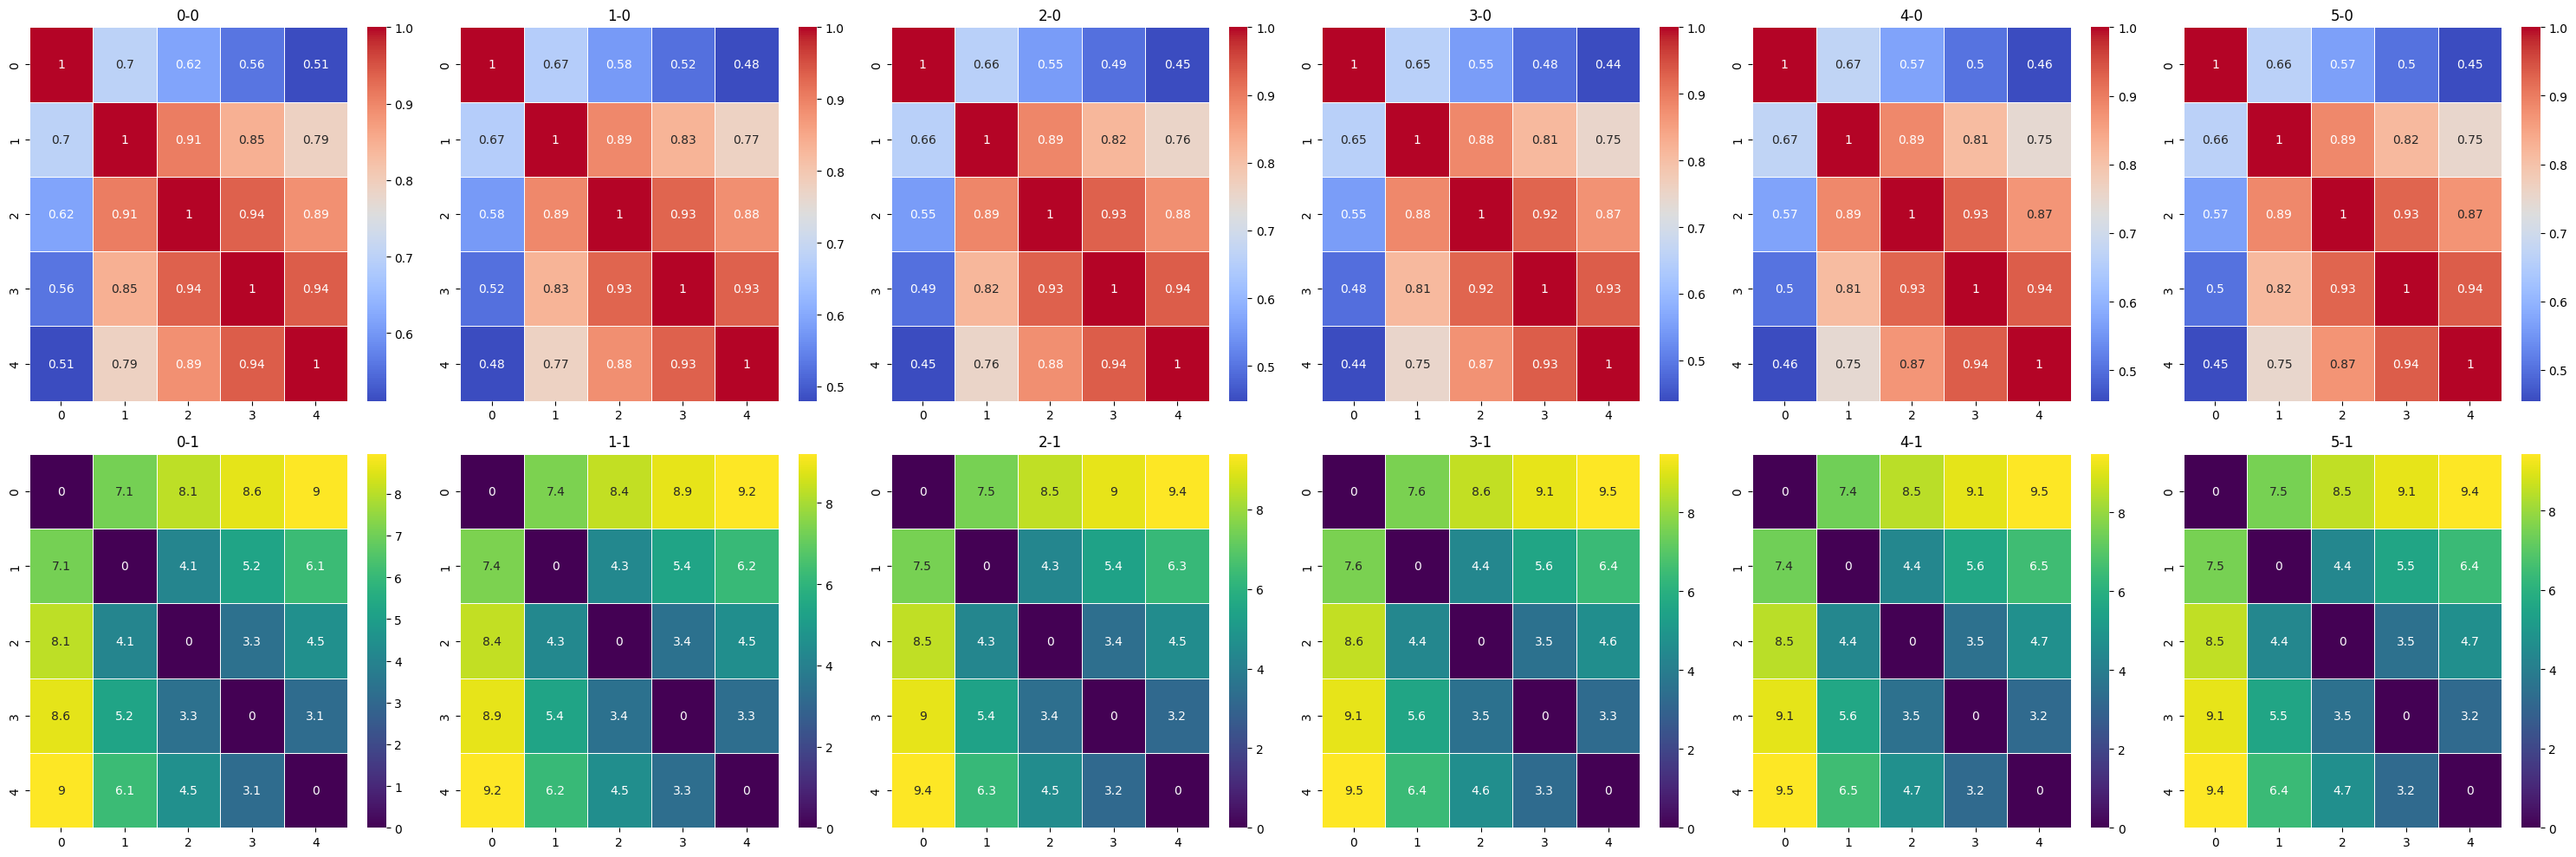

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# 创建一个 2x5 的子图布局
fig, axes = plt.subplots(2, 6, figsize=(30, 10))
for i, (key, v) in enumerate(adaptive_exp.summaries.items()):
    sns.heatmap(v['metrics'][0], ax=axes[0, i], annot=True, cmap="coolwarm", linewidths=.5)
    axes[0, i].set_title(f"{key}-0")
    sns.heatmap(v['metrics'][1], ax=axes[1, i], annot=True, cmap="viridis", linewidths=.5)
    axes[1, i].set_title(f"{key}-1")

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()